In [80]:
import torch

In [81]:
from torchvision import transforms

In [82]:
from PIL import Image

In [83]:
import numpy as np

In [84]:
import matplotlib.pyplot as plt

In [85]:
import pickle

In [86]:
from timm import models

In [87]:
import random

In [88]:
from collections import OrderedDict

In [89]:
from traffickcam_model_training.src.traffickcam_folder import TraffickcamFolderPaths

In [90]:
%matplotlib inline

In [91]:
device = torch.device("cuda")
print(device)

cuda


In [92]:
# Load model checkpoint
checkpoint_path = "/home/tun78940/tcam/tcam_training/traffickcam_model_training/models/latest_checkpoint.pth.tar"
model = models.vit_base_patch16_224_in21k(pretrained=True)
model.head = torch.nn.Identity()
model.cuda()

model = torch.nn.DataParallel(model)

checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint['state_dict']

model.load_state_dict(state_dict)

model.eval()

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=3072

In [93]:
# Define transformations
transform = [transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
# Specify image transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
rotate = transforms.RandomApply([transforms.RandomRotation((-35, 35))], p=.2)
color_jitter = transforms.RandomApply([transforms.ColorJitter(brightness=.25, hue=.15, saturation=.05)], p=.4)
train_transforms = [transforms.Resize(256), transforms.RandomCrop(224), 
                    rotate, color_jitter, transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(), normalize]

In [94]:
# load pickle lists containing the paths to each image set
with open('/home/tun78940/tcam/tcam_training/traffickcam_model_training/src/train_imgs.dat', 'rb') as f:
    train_set = pickle.load(f)
    f.close()
with open("/home/tun78940/tcam/tcam_training/traffickcam_model_training/src/gallery_imgs.dat", 'rb') as f:
    gallery_paths = pickle.load(f)
    f.close()
with open('/home/tun78940/tcam/tcam_training/traffickcam_model_training/src/validation_queries.dat', 'rb') as f:
    query_paths = pickle.load(f)
    f.close()

train_set = [file for file in train_set if not file.endswith(".txt")]
gallery_paths = [file for file in gallery_paths if not file.endswith(".txt")]
query_paths = [file for file in query_paths if not file.endswith(".txt")]

# Load the dataset through TraffickCamFolderPaths to retrieve paths, labels and targets
train_folder = TraffickcamFolderPaths(train_set, transform=transforms.Compose(train_transforms),
                                      camera_type_dict=None)

#gallery_paths = random.sample(gallery_paths, 1000)
gallery_folder = TraffickcamFolderPaths(gallery_paths, classes=train_folder.classes,
                                            transform=transforms.Compose(transform))
gallery_loader = torch.utils.data.DataLoader(gallery_folder, batch_size=128, shuffle=False,
                                                 num_workers=4, pin_memory=True)

# Take a query image in the validation set and embed
query_paths = random.sample(query_paths, 1)
query_folder = TraffickcamFolderPaths(query_paths, classes=train_folder.classes,
                                            transform=transforms.Compose(transform))
query_loader = torch.utils.data.DataLoader(query_folder, batch_size=128, shuffle=False,
                                                 num_workers=4, pin_memory=True)

loaders_dict = {'val_query': query_loader,
                'gallery': gallery_loader}

0 hotels missing out of 7632943
0 hotels missing out of 53143
0 hotels missing out of 1


In [95]:
#Embed function to get paths and labels from GALLERY
gallery_loader = loaders_dict['gallery']
gallery_embeddings = torch.Tensor([])
gallery_labels = torch.Tensor([])
gallery_paths = []
    
model.eval()
with torch.no_grad():
    for i, (inputs, labels, paths) in enumerate(gallery_loader):
        inputs = inputs.cuda()
        embeddings = model(inputs)
        gallery_embeddings = torch.cat((gallery_embeddings, embeddings.detach().cpu()))
        gallery_labels = torch.cat((gallery_labels, labels))
        gallery_paths = gallery_paths + paths

In [96]:
gallery_embeddings = np.array(gallery_embeddings)
gallery_labels = np.array(gallery_labels)

In [97]:
# print("Gal_embeddings:", gallery_embeddings,
#      "Gal_labels:", gallery_labels, "Gal_paths:", gallery_paths)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [98]:
#Embed function to get paths and labels from QUERY
query_loader = loaders_dict['val_query']
query_embeddings = torch.Tensor([])
query_labels = torch.Tensor([])
query_paths = []
    
model.eval()
with torch.no_grad():
    for i, (inputs, labels, paths) in enumerate(query_loader):
        inputs = inputs.cuda()
        embeddings = model(inputs)
        query_embeddings = torch.cat((query_embeddings, embeddings.detach().cpu()))
        query_labels = torch.cat((query_labels, labels))
        query_paths = query_paths + paths

In [99]:
query_embeddings = np.array(query_embeddings)
query_labels = np.array(query_labels)

In [100]:
# print("Query_embeddings:", query_embeddings,
#      "Query_labels:", query_labels, "Query_paths:", query_paths)

Query_embeddings: [[ 3.95214009e+00 -2.61749983e+00  2.95848465e+00  1.83925080e+00
   3.34767556e+00  3.00487089e+00  3.24498892e-01  3.47155619e+00
  -1.77463734e+00 -4.58583748e-03 -4.04521257e-01 -6.34427845e-01
  -4.02858883e-01  5.66694617e-01 -6.53674543e-01  4.13067639e-01
   7.44892061e-01 -1.13609672e+00  1.14709163e+00 -2.83872390e+00
  -5.72842956e-01  1.03398785e-01 -1.53605127e+00 -3.36306095e+00
   4.28235483e+00  2.07265043e+00  1.53948832e+00 -1.22460254e-01
  -1.06321259e+01  3.34809780e+00 -4.99222279e-01  8.17005992e-01
   9.87039447e-01 -1.27363169e+00 -2.56016970e+00 -1.63342357e+00
   1.31669402e+00  3.29332089e+00  3.32585037e-01  2.20762277e+00
  -3.30844855e+00 -5.45357180e+00  3.96980190e+00 -8.66359413e-01
   2.97751781e-02 -1.07136762e+00 -3.06432676e+00  5.86930513e-01
   5.11639535e-01  4.72100878e+00 -2.49512196e+00  4.55611497e-01
   2.47050333e+00  3.61767983e+00  2.46001983e+00 -6.55032301e+00
   6.46361932e-02  9.30611551e-01 -1.53598115e-01 -1.45498

In [101]:
# gallery_embeddings = []
# for path in gallery_paths:
#     img = Image.open(path).convert("RGB")
#     img_tensor = transform(img).unsqueeze(0).to(device)
#     with torch.no_grad():
#         embedding = model(img_tensor)
#     gallery_embeddings.append(embedding.squeeze().cpu().numpy())

# gallery_embeddings = np.array(gallery_embeddings)

In [102]:
# Take a query image in the validation set and embed
# query_path = "/shared/data/Traffickcam/full-apr20/00/0010/6102588_1032.jpg"

In [103]:
# query_img = Image.open(query_path).convert('RGB')
# query_img_tensor = transform(query_img).unsqueeze(0).to(device)
# with torch.no_grad():
#     query_embedding = model(query_img_tensor).squeeze().cpu().numpy()

In [104]:
# Perform nearest neighbor search
#TODO FAISS
distances = np.linalg.norm(gallery_embeddings - query_embeddings, axis=1)
nearest_indices = np.argsort(distances)[:5]  # Change the number 5 to the desired number of neighbors

In [105]:
# # Visual inspection of query and nearest neighbors
# fig, axes = plt.subplots(1, 6, figsize=(15, 5))
# axes[0].imshow(query_img)
# axes[0].set_title("Query")

# gallery_paths = list(gallery_paths)

# for i, index in enumerate(nearest_indices):
#     print("Gallery Paths:",gallery_paths[index])
#     img = Image.open(gallery_paths[index])
#     axes[i+1].imshow(img)
#     axes[i+1].set_title(f"Neighbor {i+1}")
#     #print("axes",axes)
    
# plt.tight_layout()
# plt.show()

Gallery Paths: /shared/data/Traffickcam/full-apr20/02/0242/3881957_24256.jpg
Gallery Paths: /shared/data/Traffickcam/full-apr20/08/0817/3988356_81789.jpg
Gallery Paths: /shared/data/Traffickcam/full-apr20/08/0854/3839027_85470.jpg
Gallery Paths: /shared/data/Traffickcam/full-apr20/03/0334/3986990_33486.jpg
Gallery Paths: /shared/data/Traffickcam/full-apr20/04/0427/3939526_42776.jpg


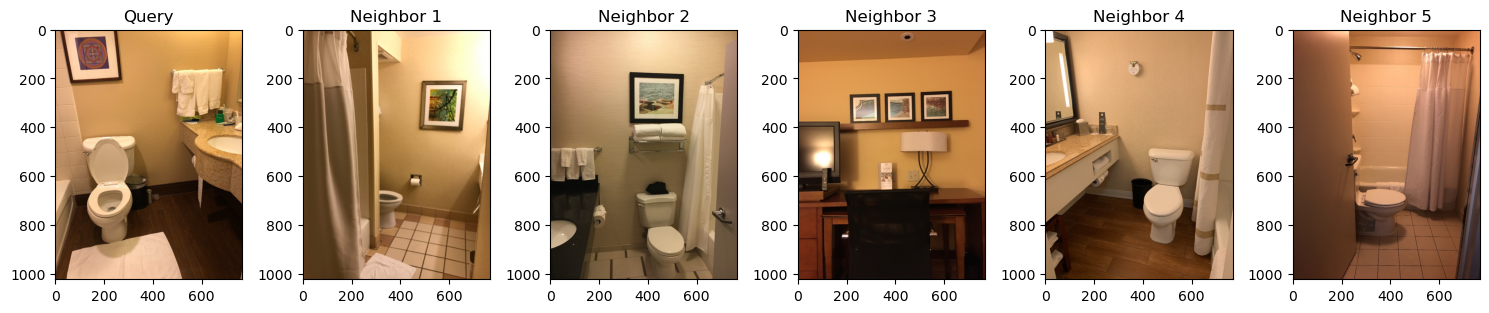

In [106]:
# Visual inspection of query and nearest neighbors
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
query_img = Image.open(query_paths[0])
print("Query Paths:",query_paths[0])
axes[0].imshow(query_img)
axes[0].set_title("Query")

gallery_paths = list(gallery_paths)

for i, index in enumerate(nearest_indices):
    print("Gallery Paths:",gallery_paths[index])
    img = Image.open(gallery_paths[index])
    axes[i+1].imshow(img)
    axes[i+1].set_title(f"Neighbor {i+1}")
    
plt.tight_layout()
plt.show()